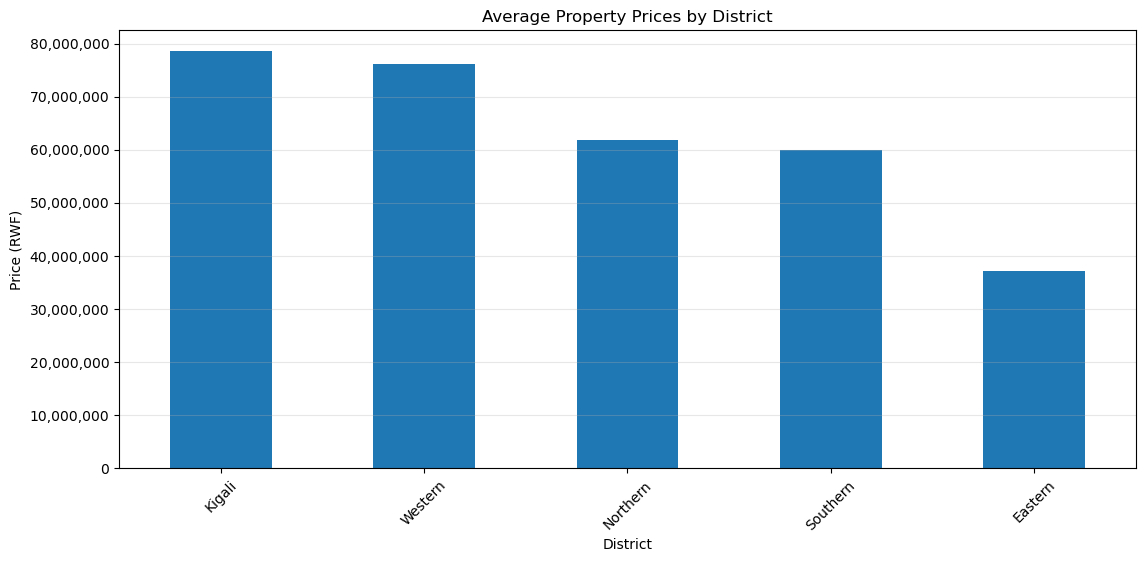

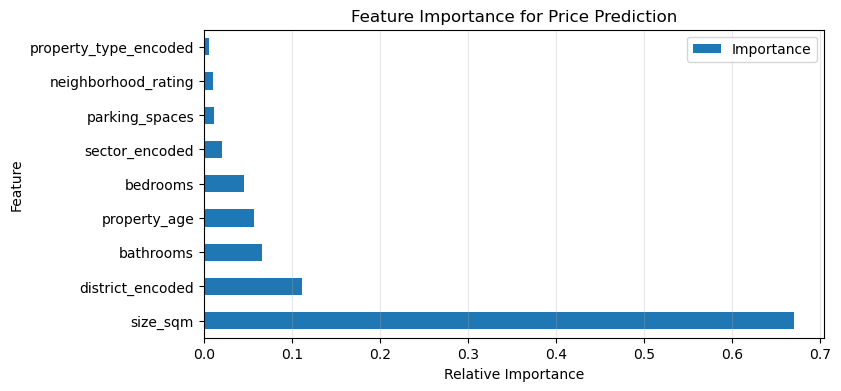

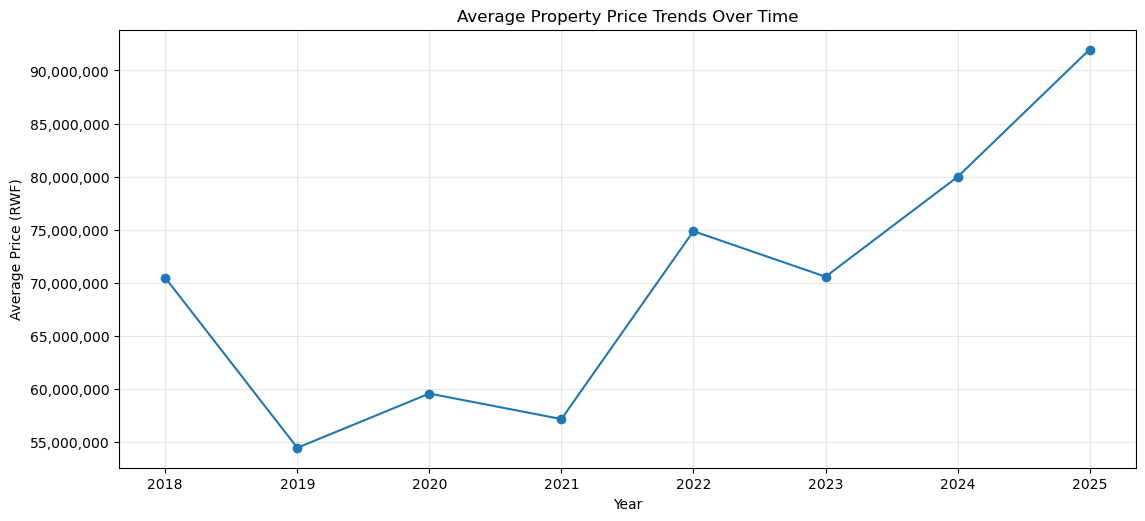

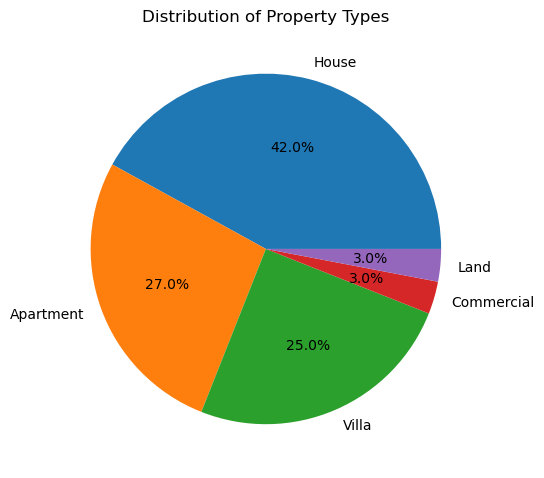

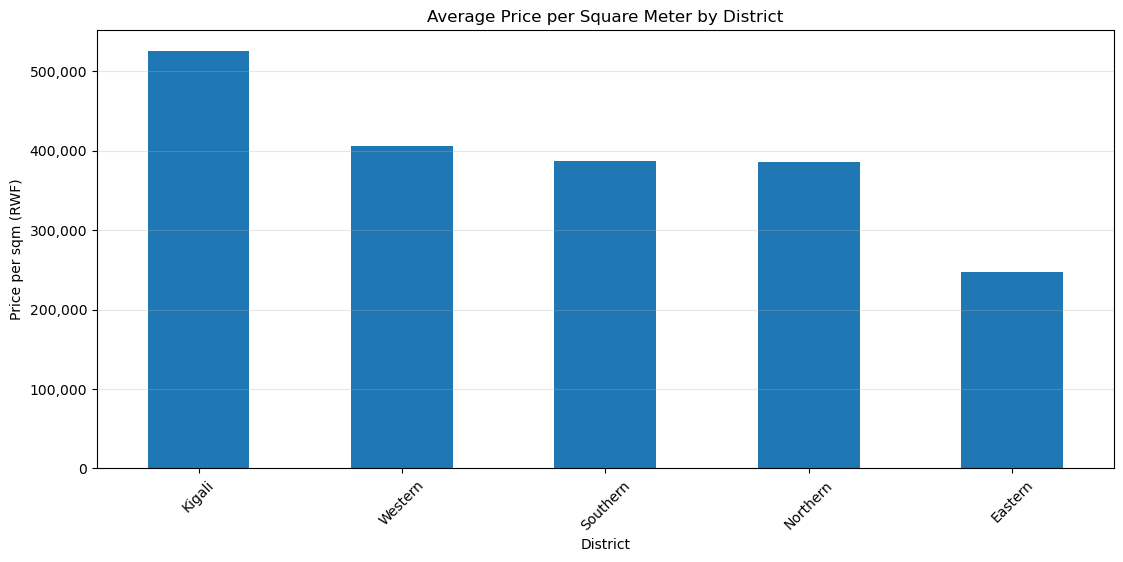

In [6]:
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import messagebox, ttk
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import datetime as dt

# Load the dataset
def load_data():
    try:
        data = pd.read_csv(r'C:\Users\Ngoga\Downloads\rwanda_real_estate_dataset.csv')
        # Convert sell_date to datetime
        data['sell_date'] = pd.to_datetime(data['sell_date'])
        data['sell_year'] = data['sell_date'].dt.year
        data['sell_month'] = data['sell_date'].dt.month
        
        # Calculate property age
        data['property_age'] = data.apply(
            lambda row: row['sell_year'] - row['year_built'] if row['year_built'] > 0 else np.nan, 
            axis=1
        )
        
        # Create price per sqm
        data['price_per_sqm'] = data['price_rwf'] / data['size_sqm']
        
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Data Pre-processing
def preprocess_data(data):
    # Drop rows with missing values in essential columns
    essential_cols = ['district', 'property_type', 'size_sqm', 'price_rwf']
    data = data.dropna(subset=essential_cols)
    
    # Encode categorical variables
    label_encoders = {}
    categorical_cols = ['district', 'sector', 'property_type', 'furnished', 
                       'property_condition', 'road_access', 'view_type', 
                       'ownership_type', 'listing_type']
    
    for col in categorical_cols:
        if col in data.columns:
            le = LabelEncoder()
            data[f'{col}_encoded'] = le.fit_transform(data[col].astype(str))
            label_encoders[col] = le
    
    return data, label_encoders

# Build prediction model
def build_model(data):
    # Define features and target
    features = ['district_encoded', 'sector_encoded', 'property_type_encoded',
               'size_sqm', 'bedrooms', 'bathrooms', 'property_age', 
               'neighborhood_rating', 'parking_spaces']
    
    # Filter valid features
    valid_features = [f for f in features if f in data.columns]
    
    X = data[valid_features].copy()
    y = data['price_rwf']
    
    # Fill remaining NaN values with median
    for col in X.columns:
        X[col] = X[col].fillna(X[col].median())
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict & Evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return model, valid_features, mae, r2

# Calculate investment metrics
def calculate_investment_metrics(data):
    # Assume 8% annual rental yield for simplicity
    data['estimated_annual_rental'] = data['price_rwf'] * 0.08
    data['rent_to_price_ratio'] = data['estimated_annual_rental'] / data['price_rwf']
    
    investment_opportunities = data[[
        'district', 'sector', 'property_type', 'size_sqm', 'bedrooms',
        'price_rwf', 'estimated_annual_rental', 'rent_to_price_ratio'
    ]].sort_values('rent_to_price_ratio', ascending=False)
    
    return investment_opportunities

# Main Application
class RealEstateApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Rwanda Real Estate Market Analysis")
        self.root.geometry("1100x700")
        
        # Load and preprocess data
        self.data = load_data()
        if self.data is None:
            messagebox.showerror("Error", "Failed to load dataset. Please check the file path.")
            root.destroy()
            return
            
        self.data, self.label_encoders = preprocess_data(self.data)
        self.model, self.model_features, self.mae, self.r2 = build_model(self.data)
        self.investment_opportunities = calculate_investment_metrics(self.data)
        
        # Create notebook for tabs
        self.notebook = ttk.Notebook(root)
        self.notebook.pack(fill='both', expand=True, padx=10, pady=10)
        
        # Create tabs
        self.price_prediction_tab = ttk.Frame(self.notebook)
        self.market_analysis_tab = ttk.Frame(self.notebook)
        self.investment_tab = ttk.Frame(self.notebook)
        
        self.notebook.add(self.price_prediction_tab, text="Price Prediction")
        self.notebook.add(self.market_analysis_tab, text="Market Analysis")
        self.notebook.add(self.investment_tab, text="Investment Opportunities")
        
        # Setup each tab
        self.setup_price_prediction_tab()
        self.setup_market_analysis_tab()
        self.setup_investment_tab()
        
    def setup_price_prediction_tab(self):
        frame = self.price_prediction_tab
        
        # Left panel for inputs
        input_frame = ttk.LabelFrame(frame, text="Property Information")
        input_frame.grid(row=0, column=0, padx=10, pady=10, sticky="n")
        
        # Input fields
        self.input_vars = {}
        
        # District
        ttk.Label(input_frame, text="District:").grid(row=0, column=0, padx=5, pady=5, sticky="w")
        district_var = tk.StringVar()
        districts = sorted(self.data['district'].unique())
        ttk.Combobox(input_frame, textvariable=district_var, values=districts, state='readonly').grid(
            row=0, column=1, padx=5, pady=5, sticky="we")
        self.input_vars['district'] = district_var
        
        # Sector
        ttk.Label(input_frame, text="Sector:").grid(row=1, column=0, padx=5, pady=5, sticky="w")
        sector_var = tk.StringVar()
        sectors = sorted(self.data['sector'].unique())
        ttk.Combobox(input_frame, textvariable=sector_var, values=sectors, state='readonly').grid(
            row=1, column=1, padx=5, pady=5, sticky="we")
        self.input_vars['sector'] = sector_var
        
        # Property Type
        ttk.Label(input_frame, text="Property Type:").grid(row=2, column=0, padx=5, pady=5, sticky="w")
        property_type_var = tk.StringVar()
        property_types = sorted(self.data['property_type'].unique())
        ttk.Combobox(input_frame, textvariable=property_type_var, values=property_types, state='readonly').grid(
            row=2, column=1, padx=5, pady=5, sticky="we")
        self.input_vars['property_type'] = property_type_var
        
        # Size
        ttk.Label(input_frame, text="Size (sqm):").grid(row=3, column=0, padx=5, pady=5, sticky="w")
        size_var = tk.StringVar()
        ttk.Entry(input_frame, textvariable=size_var).grid(row=3, column=1, padx=5, pady=5, sticky="we")
        self.input_vars['size_sqm'] = size_var
        
        # Bedrooms
        ttk.Label(input_frame, text="Bedrooms:").grid(row=4, column=0, padx=5, pady=5, sticky="w")
        bedrooms_var = tk.StringVar()
        ttk.Combobox(input_frame, textvariable=bedrooms_var, values=list(range(1, 7)), state='readonly').grid(
            row=4, column=1, padx=5, pady=5, sticky="we")
        self.input_vars['bedrooms'] = bedrooms_var
        
        # Bathrooms
        ttk.Label(input_frame, text="Bathrooms:").grid(row=5, column=0, padx=5, pady=5, sticky="w")
        bathrooms_var = tk.StringVar()
        ttk.Combobox(input_frame, textvariable=bathrooms_var, values=list(range(1, 5)), state='readonly').grid(
            row=5, column=1, padx=5, pady=5, sticky="we")
        self.input_vars['bathrooms'] = bathrooms_var
        
        # Year Built
        ttk.Label(input_frame, text="Year Built:").grid(row=6, column=0, padx=5, pady=5, sticky="w")
        year_built_var = tk.StringVar()
        current_year = dt.datetime.now().year
        years = list(range(2000, current_year + 1))
        ttk.Combobox(input_frame, textvariable=year_built_var, values=years, state='readonly').grid(
            row=6, column=1, padx=5, pady=5, sticky="we")
        self.input_vars['year_built'] = year_built_var
        
        # Neighborhood Rating
        ttk.Label(input_frame, text="Neighborhood Rating (1-5):").grid(row=7, column=0, padx=5, pady=5, sticky="w")
        rating_var = tk.StringVar()
        ttk.Combobox(input_frame, textvariable=rating_var, values=[1, 2, 3, 4, 5], state='readonly').grid(
            row=7, column=1, padx=5, pady=5, sticky="we")
        self.input_vars['neighborhood_rating'] = rating_var
        
        # Parking Spaces
        ttk.Label(input_frame, text="Parking Spaces:").grid(row=8, column=0, padx=5, pady=5, sticky="w")
        parking_var = tk.StringVar()
        ttk.Combobox(input_frame, textvariable=parking_var, values=list(range(0, 6)), state='readonly').grid(
            row=8, column=1, padx=5, pady=5, sticky="we")
        self.input_vars['parking_spaces'] = parking_var
        
        # Furnished
        ttk.Label(input_frame, text="Furnished:").grid(row=9, column=0, padx=5, pady=5, sticky="w")
        furnished_var = tk.StringVar()
        ttk.Combobox(input_frame, textvariable=furnished_var, values=["Yes", "No"], state='readonly').grid(
            row=9, column=1, padx=5, pady=5, sticky="we")
        self.input_vars['furnished'] = furnished_var
        
        # Predict button
        predict_btn = ttk.Button(input_frame, text="Predict Price", command=self.predict_price)
        predict_btn.grid(row=10, column=0, columnspan=2, padx=5, pady=15)
        
        # Model info
        info_frame = ttk.LabelFrame(input_frame, text="Model Information")
        info_frame.grid(row=11, column=0, columnspan=2, padx=5, pady=10, sticky="we")
        
        ttk.Label(info_frame, text=f"Model Mean Absolute Error: {self.mae:,.0f} RWF").pack(anchor="w", padx=5, pady=2)
        ttk.Label(info_frame, text=f"Model R² Score: {self.r2:.4f}").pack(anchor="w", padx=5, pady=2)
        
        # Right panel for results and similar properties
        result_frame = ttk.LabelFrame(frame, text="Prediction Results")
        result_frame.grid(row=0, column=1, padx=10, pady=10, sticky="n")
        
        # Prediction result
        self.result_label = ttk.Label(result_frame, text="Enter property details and click 'Predict Price'", font=('Arial', 12))
        self.result_label.pack(padx=20, pady=20)
        
        # Feature importance visualization
        importance_frame = ttk.LabelFrame(frame, text="Feature Importance")
        importance_frame.grid(row=1, column=0, columnspan=2, padx=10, pady=10, sticky="nsew")
        
        fig, ax = plt.subplots(figsize=(8, 4))
        feature_importance = pd.DataFrame({
            'Feature': self.model_features,
            'Importance': self.model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        feature_importance.plot(kind='barh', x='Feature', y='Importance', ax=ax)
        ax.set_title('Feature Importance for Price Prediction')
        ax.set_xlabel('Relative Importance')
        ax.grid(axis='x', alpha=0.3)
        
        canvas = FigureCanvasTkAgg(fig, master=importance_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
    def setup_market_analysis_tab(self):
        frame = self.market_analysis_tab
        
        # Create a frame for the visualizations
        vis_frame = ttk.Frame(frame)
        vis_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Add visualization options
        options_frame = ttk.LabelFrame(vis_frame, text="Select Visualization")
        options_frame.pack(fill='x', padx=5, pady=5)
        
        viz_var = tk.StringVar(value="Price by District")
        viz_options = [
            "Price by District", 
            "Price Trends Over Time", 
            "Property Type Distribution",
            "Price per Square Meter"
        ]
        
        for i, option in enumerate(viz_options):
            ttk.Radiobutton(options_frame, text=option, value=option, variable=viz_var, 
                           command=lambda: self.update_visualization(viz_var.get())).grid(
                row=0, column=i, padx=10, pady=5)
        
        # Frame for the visualization
        self.chart_frame = ttk.Frame(vis_frame)
        self.chart_frame.pack(fill=tk.BOTH, expand=True, padx=5, pady=5)
        
        # Initialize with default visualization
        self.current_chart = None
        self.update_visualization("Price by District")
        
    def setup_investment_tab(self):
        frame = self.investment_tab
        
        # Create filter frame
        filter_frame = ttk.LabelFrame(frame, text="Filter Investment Opportunities")
        filter_frame.pack(fill='x', padx=10, pady=10)
        
        # District filter
        ttk.Label(filter_frame, text="District:").grid(row=0, column=0, padx=5, pady=5)
        district_var = tk.StringVar(value="All")
        districts = ["All"] + sorted(self.data['district'].unique())
        ttk.Combobox(filter_frame, textvariable=district_var, values=districts, state='readonly', width=15).grid(
            row=0, column=1, padx=5, pady=5)
        
        # Property type filter
        # Property type filter
        ttk.Label(filter_frame, text="Property Type:").grid(row=0, column=2, padx=5, pady=5)
        property_type_var = tk.StringVar(value="All")
        property_types = ["All"] + sorted(self.data['property_type'].unique())
        ttk.Combobox(filter_frame, textvariable=property_type_var, values=property_types, state='readonly', width=15).grid(
            row=0, column=3, padx=5, pady=5)
        
        # Min budget filter
        ttk.Label(filter_frame, text="Min Budget (RWF):").grid(row=0, column=4, padx=5, pady=5)
        min_budget_var = tk.StringVar(value="0")
        ttk.Entry(filter_frame, textvariable=min_budget_var, width=15).grid(row=0, column=5, padx=5, pady=5)
        
        # Max budget filter
        ttk.Label(filter_frame, text="Max Budget (RWF):").grid(row=0, column=6, padx=5, pady=5)
        max_budget_var = tk.StringVar(value="200000000")
        ttk.Entry(filter_frame, textvariable=max_budget_var, width=15).grid(row=0, column=7, padx=5, pady=5)
        
        # Apply filters button
        apply_btn = ttk.Button(filter_frame, text="Apply Filters", 
                              command=lambda: self.update_investment_table(district_var.get(), 
                                                                           property_type_var.get(),
                                                                           min_budget_var.get(),
                                                                           max_budget_var.get()))
        apply_btn.grid(row=0, column=8, padx=10, pady=5)
        
        # Create table for investment opportunities
        table_frame = ttk.Frame(frame)
        table_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Create Treeview for investment opportunities
        self.investment_tree = ttk.Treeview(table_frame)
        self.investment_tree["columns"] = ("District", "Sector", "Type", "Size (sqm)", "Bedrooms", 
                                         "Price (RWF)", "Est. Annual Rent", "Rent/Price Ratio")
        
        # Configure columns
        self.investment_tree.column("#0", width=0, stretch=tk.NO)
        for col in self.investment_tree["columns"]:
            self.investment_tree.column(col, anchor=tk.CENTER, width=120)
            self.investment_tree.heading(col, text=col, anchor=tk.CENTER)
        
        # Add vertical scrollbar
        scrollbar = ttk.Scrollbar(table_frame, orient="vertical", command=self.investment_tree.yview)
        self.investment_tree.configure(yscrollcommand=scrollbar.set)
        
        # Pack everything
        self.investment_tree.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        
        # Initialize with default data
        self.update_investment_table("All", "All", "0", "200000000")
        
    def predict_price(self):
        try:
            # Get input values
            district = self.input_vars['district'].get()
            sector = self.input_vars['sector'].get()
            property_type = self.input_vars['property_type'].get()
            size_sqm = float(self.input_vars['size_sqm'].get())
            bedrooms = int(self.input_vars['bedrooms'].get())
            bathrooms = int(self.input_vars['bathrooms'].get())
            year_built = int(self.input_vars['year_built'].get())
            neighborhood_rating = float(self.input_vars['neighborhood_rating'].get())
            parking_spaces = int(self.input_vars['parking_spaces'].get())
            furnished = self.input_vars['furnished'].get()
            
            # Calculate property age
            current_year = dt.datetime.now().year
            property_age = current_year - year_built
            
            # Prepare input data
            input_data = pd.DataFrame({
                'district': [district],
                'sector': [sector],
                'property_type': [property_type],
                'size_sqm': [size_sqm],
                'bedrooms': [bedrooms],
                'bathrooms': [bathrooms],
                'property_age': [property_age],
                'neighborhood_rating': [neighborhood_rating],
                'parking_spaces': [parking_spaces],
                'furnished': [furnished]
            })
            
            # Encode categorical variables
            for col in ['district', 'sector', 'property_type', 'furnished']:
                if col in input_data.columns:
                    # Check if value exists in the encoder
                    encoder = self.label_encoders.get(col)
                    if encoder:
                        try:
                            input_data[f'{col}_encoded'] = encoder.transform(input_data[col].astype(str))
                        except:
                            # Handle unknown values
                            input_data[f'{col}_encoded'] = 0
            
            # Extract only the features needed for prediction
            valid_features = [f for f in self.model_features if f in input_data.columns]
            
            # Fill any missing features with median values
            for feature in self.model_features:
                if feature not in input_data.columns:
                    input_data[feature] = self.data[feature].median()
            
            # Make prediction
            prediction = self.model.predict(input_data[self.model_features])[0]
            
            # Update result label
            self.result_label.config(text=f"Estimated Property Value: {prediction:,.0f} RWF\n(${prediction/1200:,.2f} USD)")
            
            # Find similar properties
            self.show_similar_properties(district, property_type, size_sqm, bedrooms, prediction)
            
        except Exception as e:
            messagebox.showerror("Error", f"Prediction error: {str(e)}")
    
    def show_similar_properties(self, district, property_type, size_sqm, bedrooms, predicted_price):
        # Find similar properties
        similar = self.data[(self.data['district'] == district) & 
                           (self.data['property_type'] == property_type) &
                           (self.data['bedrooms'] == bedrooms) &
                           (self.data['size_sqm'].between(size_sqm * 0.8, size_sqm * 1.2))]
        
        # If no similar properties found, broaden the search
        if len(similar) < 3:
            similar = self.data[(self.data['district'] == district) & 
                               (self.data['property_type'] == property_type)]
            
            # If still no similar properties, just get properties in the same district
            if len(similar) < 3:
                similar = self.data[(self.data['district'] == district)]
        
        # If we have similar properties, create a table to display them
        if len(similar) > 0:
            # Create a new window for similar properties
            similar_window = tk.Toplevel(self.root)
            similar_window.title("Similar Properties")
            similar_window.geometry("800x400")
            
            # Create Treeview
            similar_tree = ttk.Treeview(similar_window)
            similar_tree["columns"] = ("Property Type", "Size (sqm)", "Bedrooms", "Bathrooms", 
                                     "Year Built", "Price (RWF)", "Price/sqm")
            
            # Configure columns
            similar_tree.column("#0", width=0, stretch=tk.NO)
            for col in similar_tree["columns"]:
                similar_tree.column(col, anchor=tk.CENTER)
                similar_tree.heading(col, text=col, anchor=tk.CENTER)
            
            # Add data
            for i, (_, row) in enumerate(similar.iterrows()):
                price_per_sqm = row['price_rwf'] / row['size_sqm'] if row['size_sqm'] > 0 else 0
                similar_tree.insert(parent="", index=i, iid=i, values=(
                    row['property_type'],
                    f"{row['size_sqm']:.0f}",
                    row['bedrooms'],
                    row['bathrooms'],
                    row['year_built'],
                    f"{row['price_rwf']:,.0f}",
                    f"{price_per_sqm:,.0f}"
                ))
            
            # Add scrollbar
            scrollbar = ttk.Scrollbar(similar_window, orient="vertical", command=similar_tree.yview)
            similar_tree.configure(yscrollcommand=scrollbar.set)
            
            # Pack everything
            similar_tree.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
            scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
            
    def update_visualization(self, viz_type):
        # Clear previous chart if exists
        for widget in self.chart_frame.winfo_children():
            widget.destroy()
        
        # Create figure and axes
        fig, ax = plt.subplots(figsize=(10, 6))
        
        if viz_type == "Price by District":
            # Group by district and calculate mean price
            district_prices = self.data.groupby('district')['price_rwf'].mean().sort_values(ascending=False)
            district_prices.plot(kind='bar', ax=ax)
            ax.set_title('Average Property Prices by District')
            ax.set_ylabel('Price (RWF)')
            ax.set_xlabel('District')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(axis='y', alpha=0.3)
            
            # Format y-axis labels
            ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
            
        elif viz_type == "Price Trends Over Time":
            # Group by year and calculate average price
            yearly_data = self.data.groupby('sell_year')['price_rwf'].mean()
            yearly_data.plot(marker='o', ax=ax)
            ax.set_title('Average Property Price Trends Over Time')
            ax.set_ylabel('Average Price (RWF)')
            ax.set_xlabel('Year')
            ax.grid(alpha=0.3)
            
            # Format y-axis labels
            ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
            
        elif viz_type == "Property Type Distribution":
            # Count properties by type
            type_counts = self.data['property_type'].value_counts()
            type_counts.plot(kind='pie', autopct='%1.1f%%', ax=ax)
            ax.set_title('Distribution of Property Types')
            ax.set_ylabel('')
            
        elif viz_type == "Price per Square Meter":
            # Calculate price per square meter by district
            price_per_sqm = self.data.groupby('district')['price_per_sqm'].mean().sort_values(ascending=False)
            price_per_sqm.plot(kind='bar', ax=ax)
            ax.set_title('Average Price per Square Meter by District')
            ax.set_ylabel('Price per sqm (RWF)')
            ax.set_xlabel('District')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(axis='y', alpha=0.3)
            
            # Format y-axis labels
            ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
        
        # Create canvas and add to frame
        canvas = FigureCanvasTkAgg(fig, master=self.chart_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
    def update_investment_table(self, district, property_type, min_budget, max_budget):
        # Clear existing data
        for item in self.investment_tree.get_children():
            self.investment_tree.delete(item)
        
        # Apply filters
        filtered_data = self.investment_opportunities.copy()
        
        if district != "All":
            filtered_data = filtered_data[filtered_data['district'] == district]
            
        if property_type != "All":
            filtered_data = filtered_data[filtered_data['property_type'] == property_type]
        
        try:
            min_budget = float(min_budget)
            max_budget = float(max_budget)
            filtered_data = filtered_data[(filtered_data['price_rwf'] >= min_budget) & 
                                         (filtered_data['price_rwf'] <= max_budget)]
        except:
            messagebox.showwarning("Warning", "Invalid budget values. Using all price ranges.")
        
        # Sort by rent-to-price ratio (highest first for investment potential)
        filtered_data = filtered_data.sort_values('rent_to_price_ratio', ascending=False)
        
        # Add data to table
        for i, (_, row) in enumerate(filtered_data.iterrows()):
            self.investment_tree.insert(parent="", index=i, iid=i, values=(
                row['district'],
                row['sector'],
                row['property_type'],
                f"{row['size_sqm']:.0f}",
                row['bedrooms'],
                f"{row['price_rwf']:,.0f}",
                f"{row['estimated_annual_rental']:,.0f}",
                f"{row['rent_to_price_ratio']:.4f}"
            ))

# Run application
if __name__ == "__main__":
    root = tk.Tk()
    app = RealEstateApp(root)
    root.mainloop()